# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

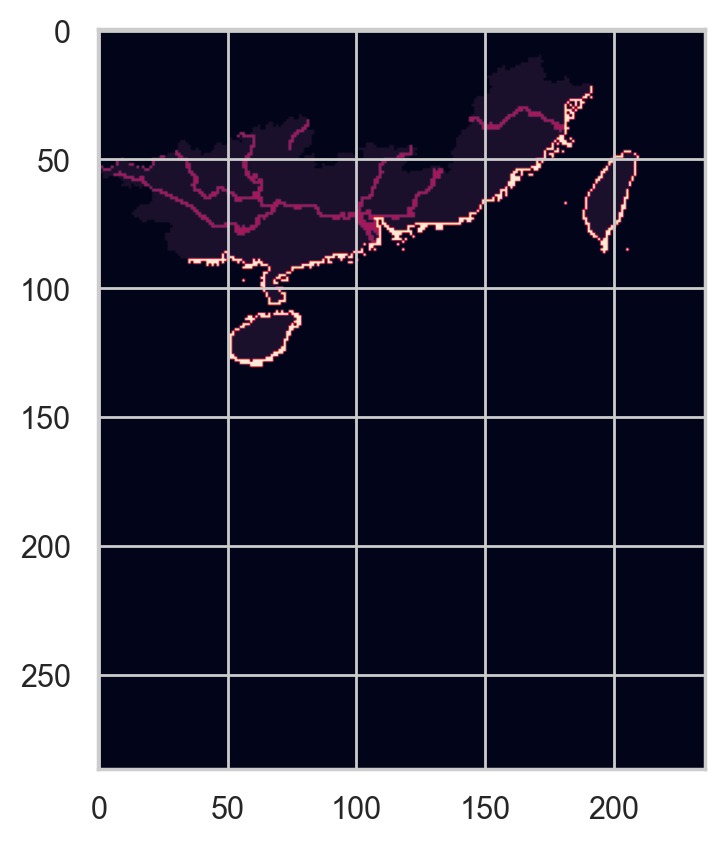

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.db.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [4]:
# 从这个路径加载模型
from src.model import Model

model = Model(parameters=cfg)

增加了初始的 Hunters，随机生成在地图上

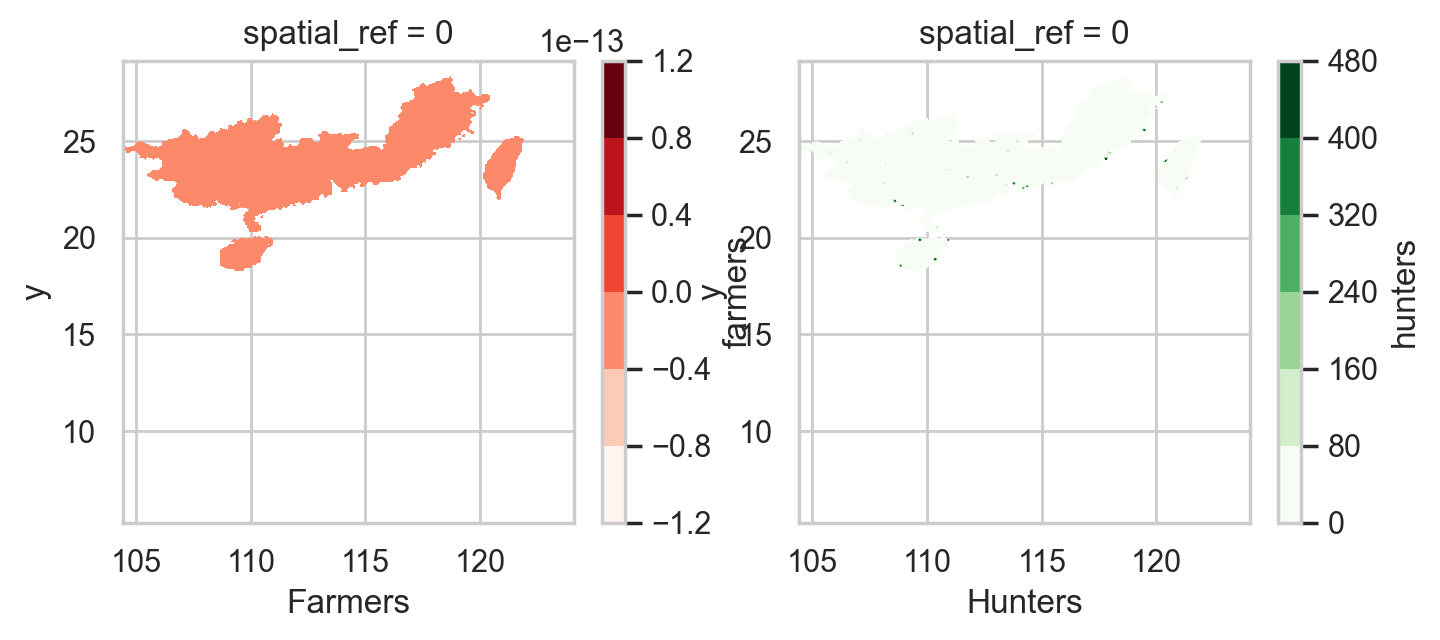

In [5]:
model.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

tick[100] 2023-11-25 18:44:09

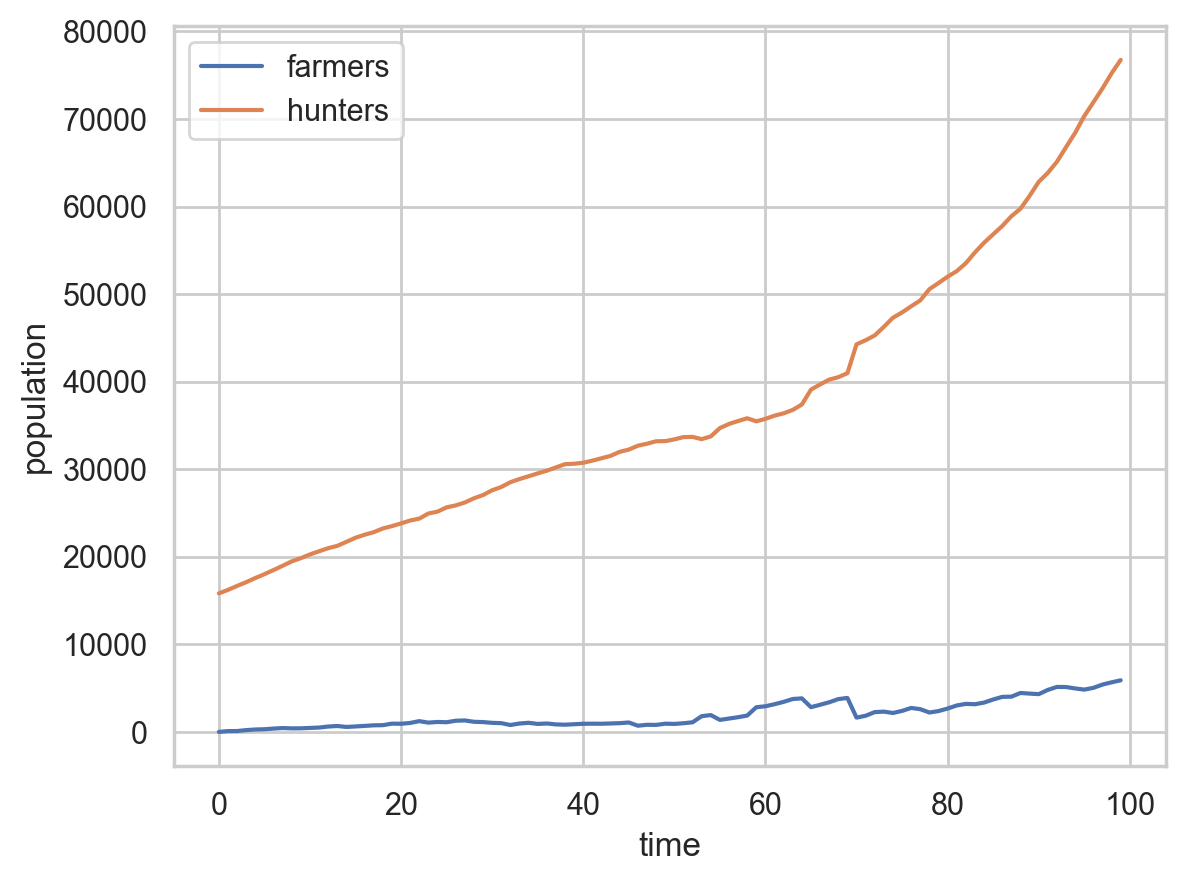

In [6]:
model.run_model()

展示主体的信息

In [7]:
agent = model.agents.to_list().random_choose()
agent.report()

unique_id         5606
breed           Hunter
size              17.0
position     (60, 202)
dtype: object

ValueError: More than one agent locates here.

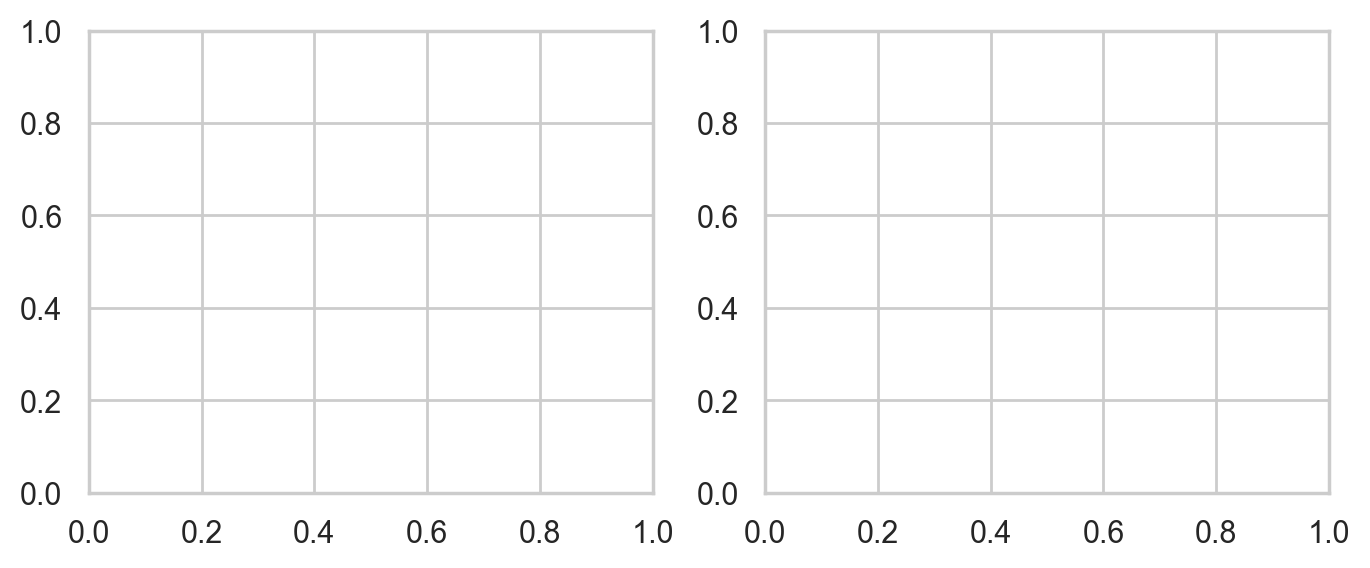

In [8]:
model.heatmap()

In [11]:
def get_agents(x):
    return len(x.agents)


agents = np.vectorize(get_agents)(model.nature.dem.array_cells)
agents

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
for cell in model.nature.dem.array_cells.ravel():
    if len(cell.agents) > 1:
        lst = cell.agents

In [14]:
lst

<ActorsList: (2)Hunter>

In [ ]:
model.hunters
model.farmers

In [ ]:
import seaborn as sns

sns.histplot(model.farmers.array("size"))

In [ ]:
sns.histplot(model.hunters.array("size"))